In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

## Load language model

In [2]:
import os

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [4]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'vietnamese', 'build') 

In [5]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
import sys, pickle, os, warnings
warnings.filterwarnings("ignore")

if __name__ == '__main__':   
    with Pool(16) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 126/126 [00:07<00:00, 17.92it/s]


In [6]:
import pandas as pd

In [7]:
pred=pd.read_csv('./ship/vietnamese/build/b04/BABEL_BP_107_54621_20120421_132410_outLine.ctm', sep='\t', header=None)
pred.columns=['file', 'channel', 'start', 'dur', 'word']

In [8]:
pred=pred[['start', 'word']].values

In [9]:
artifacts=recordings.artifacts

In [10]:
artifact=[x for x in artifacts if x.key[1]=='BABEL_BP_107_54621_20120421_132410_outLine'][0]

In [11]:
Y=artifact.source.value

In [12]:
gold=[x[3:] for x in artifact.target.value if len(x)==6]
gold=[(float(start), words) for start, finish, words in gold]
gold[0]

(11.335, 'a lô')

In [13]:
import numpy as np
T=np.arange(Y.shape[0])/C.sample_rate

In [14]:
%matplotlib inline
from matplotlib.pyplot import *

In [15]:
from load_pretrained_model import load_pretrained_model

[NeMo W 2020-10-29 12:07:29 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-29 12:07:29 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-29 12:07:29 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-29 12:07:29 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-29 12:07:29 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

In [16]:
model = load_pretrained_model(C, 0)

searching save/nemo_vietnamese/*.ckpt


[NeMo W 2020-10-29 12:07:33 modelPT:102] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: NIST/openasr20_vietnamese/build/train_manifest.json
    sample_rate: 16000
    labels:
    - ' '
    - ''''
    - '-'
    - A
    - B
    - C
    - D
    - E
    - F
    - G
    - H
    - I
    - J
    - K
    - L
    - M
    - 'N'
    - O
    - P
    - Q
    - R
    - S
    - T
    - U
    - V
    - W
    - X
    - 'Y'
    - Z
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - Á
    - Â
    - Ú
    - à
    - á
    - â
    - ã
    - è
    - é
    - ê
    - ì
    - í
    - ò
    - ó
    - ô
    - õ
    - ù
    - ú
    - ý
    - ă
    - Đ
    - đ
    - ĩ
    - ũ
    - ơ
    - ư
    - ạ
    - Ả
    - ả
    - ấ
    - ầ
  

[NeMo I 2020-10-29 12:07:33 features:241] PADDING: 16
[NeMo I 2020-10-29 12:07:33 features:258] STFT using torch
loaded save/nemo_vietnamese/vietnamese_20201029_001215_628009_epoch=99.ckpt


In [17]:
max_duration=20

In [18]:
import numpy as np
import librosa
import matplotlib.pylab as plt
from transcribe import transcribe
from collect_false import collect_false

In [19]:
audio=Y
T=audio.shape[0]/C.sample_rate

X=np.arange(audio.shape[0])/C.sample_rate

S = librosa.feature.melspectrogram(y=audio, sr=C.sample_rate, n_mels=64, fmax=8000)

dt_S=T/S.shape[1]
dt_S

samples_per_spect=int(dt_S*C.sample_rate)
samples_per_spect

S_dB = librosa.power_to_db(S, ref=np.max)
s_dB_mean=np.mean(S_dB,axis=0)

size=audio.shape[0]
max_samples=int(max_duration/dt_S)
min_samples=1

In [20]:
pred=[]

READ_HEAD 0
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 1: [(0, 87)]
advance past silence 87 87
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(17339, 3)]
cutoff -78.44221105527639 #silences 29: [(0, 2), (1107, 2), (1124, 2), (1136, 4)]
advance past silence 89 2
cutoff -78.13065326633166 #silences 106: [(468, 2), (486, 2), (491, 3), (535, 2)]
stop to read 89 557


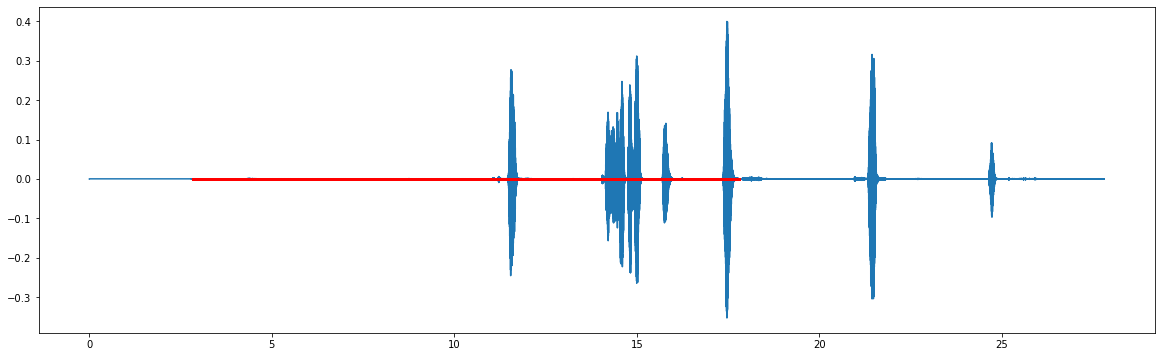

In [21]:
cutoffs = np.linspace(-80,-18,200)

read_head=0
max_read_head=s_dB_mean.shape[0]
finished=False
transcriptions=[]
while not finished and read_head < max_read_head:
    print(f"READ_HEAD {read_head}")
    for cutoff in cutoffs:
        speech_q=(s_dB_mean[read_head:]>cutoff)
        silences=collect_false(speech_q)
        silences=[(x,y) for x,y in silences if x != y and y-x > min_samples]
        n_silences = len(silences)
        print(f'cutoff {cutoff} #silences {n_silences}: {[(x[0], x[1]-x[0]) for x in silences[0:4]] if n_silences else []}')
        if n_silences==0:
            continue
        elif silences[0][0] == 0 and silences[0][1] != 0:
            read_head +=silences[0][1]
            print("advance past silence", read_head, silences[0][1])
            continue
        elif silences[0][0] > max_samples:
            continue
        else:
            silences=[(x,y) for x,y in silences if y <= max_samples]
            start_at = read_head
            stop_at= read_head + silences[-0][0]
            read_head = stop_at
            print("stop to read", start_at, stop_at)
            finished = True
            break
    read_head += max_samples

start=start_at*samples_per_spect
end=start_at+stop_at*samples_per_spect
start,end

figure(figsize=(20,6))
display_end=end+10*C.sample_rate
plot(X[0:display_end],audio[0:display_end])
plot([start/C.sample_rate,end/C.sample_rate],[0,0],color='red',linewidth=3)

In [346]:
from predicted_segment_transcript import predicted_segment_transcript

In [348]:
segment_transcript=predicted_segment_transcript(C, model, audio, start, end, s_dB_mean, samples_per_spect, dt_S)

[NeMo I 2020-10-29 18:36:27 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-29 18:36:27 collections:174] 0 files were filtered totalling 0.00 hours


In [349]:
segment_transcript

[(11.135554844899264, 0.47998081228014067, 'lô'),
 (11.615535657179404, 0.4479820914614646, 'ce'),
 (13.82344739366805, 0.3839846498241125, 'kỳ'),
 (14.207432043492163, 0.41598337064278856, 'ớ'),
 (14.623415414134952, 0.3839846498241125, 'cái'),
 (15.007400063959064, 0.41598337064278856, 'nó'),
 (15.423383434601854, 0.41598337064278856, 'chỳ'),
 (15.839366805244643, 0.3839846498241125, 'vậy'),
 (17.023319475535654, 0.3839846498241125, 'ờ'),
 (17.40730412535977, 0.3839846498241125, 'nờ')]

In [333]:
from plot_predicted_segments import plot_predicted_segments

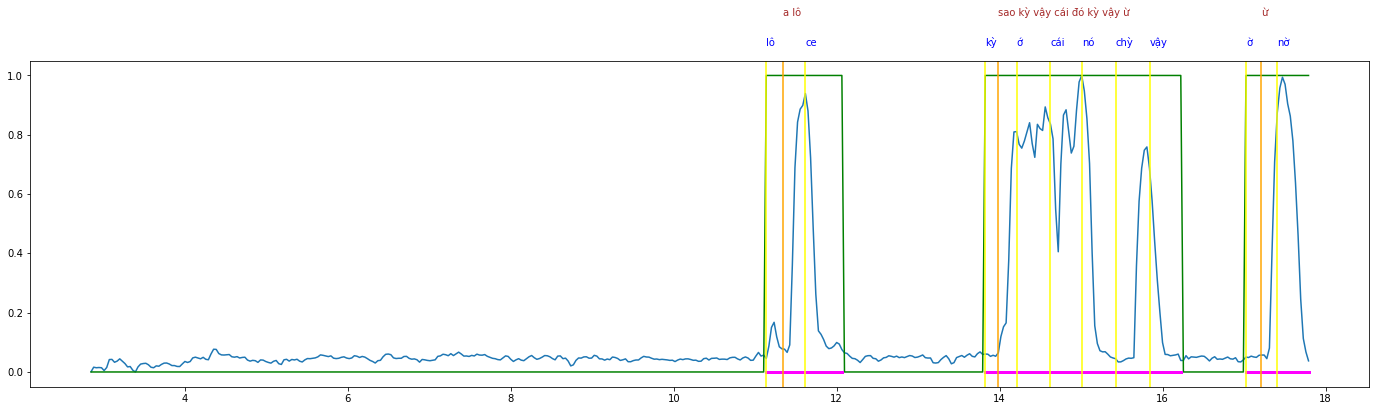

In [338]:
plot_predicted_segments(timeline, normalized_power, speech_mask, segment_transcript, gold)